# Part 1: 2 Asset Optimization

## Importing Library

In [311]:
# Import Library
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sciop
from datetime import datetime
import os

In [312]:
# User Defined Stock Tickers 
assetlist = ["META","BA","GOOGL","TSM","AAPL","VOO"]

In [313]:
# Risk Free Rate
asset_risk_free = 0.02

## Data Prep and Extraction

In [314]:
'''# Create a matrix of stock return and standard deviation
asset_risk_free = 0.05

# Generating Trial Asset list -> User Customized
assetlist = ["US", "UK", "France" ,"Germany" ,"Japan"]

# Generating Trial Asset Return Deviation Matrix -> Extract from API
asset_risk_return_dict={"Return":{"US":0.1355, "UK":0.1589,"France":0.1519,"Germany":0.1435,"Japan":0.1497},
                        "Deviation":{"US":0.1535, "UK":0.2430,"France":0.2324,"Germany":0.2038,"Japan":0.2298},
                        }

# Generating Trial Asset Correlation Matrix
asset_correlation_matrix_dict={"US":{"US":1,"UK":0.5003,"France":0.4398,"Germany":0.3681,"Japan":0.2663},
                          "UK":{"US":0.5003,"UK":1,"France":0.5420,"Germany":0.4265,"Japan":0.3581},
                          "France":{"US":0.4398,"UK":0.5420,"France":1,"Germany":0.6032,"Japan":0.3923},
                          "Germany":{"US":0.3681,"UK":0.4265,"France":0.6032,"Germany":1,"Japan":0.3663},
                          "Japan":{"US":0.2663,"UK":0.3581,"France":0.3923,"Germany":0.3663,"Japan":1}}

# Saving Matrix into pd DataFrame
asset_risk_return_df= pd.DataFrame(asset_risk_return_dict)
asset_correlation_matrix_df= pd.DataFrame(asset_correlation_matrix_dict)
'''



'# Create a matrix of stock return and standard deviation\nasset_risk_free = 0.05\n\n# Generating Trial Asset list -> User Customized\nassetlist = ["US", "UK", "France" ,"Germany" ,"Japan"]\n\n# Generating Trial Asset Return Deviation Matrix -> Extract from API\nasset_risk_return_dict={"Return":{"US":0.1355, "UK":0.1589,"France":0.1519,"Germany":0.1435,"Japan":0.1497},\n                        "Deviation":{"US":0.1535, "UK":0.2430,"France":0.2324,"Germany":0.2038,"Japan":0.2298},\n                        }\n\n# Generating Trial Asset Correlation Matrix\nasset_correlation_matrix_dict={"US":{"US":1,"UK":0.5003,"France":0.4398,"Germany":0.3681,"Japan":0.2663},\n                          "UK":{"US":0.5003,"UK":1,"France":0.5420,"Germany":0.4265,"Japan":0.3581},\n                          "France":{"US":0.4398,"UK":0.5420,"France":1,"Germany":0.6032,"Japan":0.3923},\n                          "Germany":{"US":0.3681,"UK":0.4265,"France":0.6032,"Germany":1,"Japan":0.3663},\n                  

In [315]:
# Get Stock Risk Return and Correlation

# Using YFinance to obtain stock close Price
stock_price = yf.download(tickers=assetlist,period = "10y", interval ="1mo")
# Find stock return
stock_return = stock_price["Close"].pct_change().dropna()

# Get mean and stdev of the stocks
monthly_mean_return = stock_return.mean()
monthly_stdev_return = np.std(stock_return,axis=0)

# Annualize 
mean_return = monthly_mean_return * 12
stdev_return = monthly_stdev_return * np.sqrt(12)

# Merge into a table
asset_risk_return_df = pd.DataFrame([mean_return, stdev_return],index=["Return", "Deviation"]).T 

# Get correlation between each stock
asset_correlation_matrix_df= stock_return.corr()

/var/folders/yj/_sykjyks31j7t9pdm3jfl0v00000gn/T/ipykernel_94059/665131510.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_price = yf.download(tickers=assetlist,period = "10y", interval ="1mo")
[*********************100%***********************]  6 of 6 completed


# Part 2: N Asset Optimization

### GMV Portfolio

In [316]:
# Finding Weightage of Portfolio on Global Minimum Variance

# Step 1: Get Deviations with correct order
# Define order
asset_order = asset_risk_return_df.index
# Reindex correlation matrix rows and columns
asset_correlation_matrix_df = asset_correlation_matrix_df.loc[asset_order, asset_order]
# Get deviations
deviations = asset_risk_return_df["Deviation"].values

# Step 2: Get Covariance, Element Wise
cov_matrix = np.outer(deviations, deviations) * asset_correlation_matrix_df.values

# Step 3: Define Minimum Variance Function
def global_min_var_portfolio(weights):
    return weights.T @ cov_matrix @ weights # Matrix multiplication to find variance

# Step 4: Define Constraints and Bounds
number_of_assets = len(assetlist) # asset count
init_guess = np.ones(number_of_assets)/number_of_assets # start with equal weightages
bounds = [(0,1) for a in range(number_of_assets)] # Bound the Asset weightage
constraints = {'type': 'eq', # Equality Constraint
               'fun' : lambda w : np.sum(w)-1 # Must Equal to 0
               # This constraint ensures that sum of all weight = 1
               # or sum of weight - 1 = 0
               }

# Step 5: Solve for Efficient Portfolio
gmv_result = sciop.minimize(global_min_var_portfolio, init_guess, method='SLSQP',
                bounds=bounds, constraints=constraints)

# Step 6: Output Weightages
min_variance_weights = gmv_result.x
MVP_portfolio = dict(zip(asset_order, min_variance_weights))
print(f'''
      MVP Portfolio Generated:
      {MVP_portfolio}
      ''')


      MVP Portfolio Generated:
      {'AAPL': np.float64(7.790176828445697e-18), 'BA': np.float64(1.443072433076409e-17), 'GOOGL': np.float64(0.0), 'META': np.float64(1.6922774056460794e-17), 'TSM': np.float64(4.531930166266716e-18), 'VOO': np.float64(1.0)}
      


## MVE Portfolio

In [317]:
# Finding Weightage for Mean Variance Efficient Portfolio

# Step 1: Extract Mean 
assets_mean = np.array([asset_risk_return_df["Return"][asset] for asset in assetlist])

# Step 2: Define Sharpe Formula
def negative_global_sharpe_portfolio(weights):
    mean_p = weights.T @ assets_mean
    variance = weights.T @ cov_matrix @ weights # Matrix multiplication to find variance
    return -(mean_p - asset_risk_free)/np.sqrt(variance)

# Step 3: Define Constraints and Bounds
number_of_assets = len(assetlist) # asset count
init_guess = np.ones(number_of_assets)/number_of_assets # start with equal weightages
bounds = [(0,1) for a in range(number_of_assets)] # Bound the Asset weightage
constraints = {'type': 'eq', # Equality Constraint
               'fun' : lambda w : np.sum(w)-1 # Must Equal to 0
               # This constraint ensures that sum of all weight = 1
               # or sum of weight - 1 = 0
               }

# Step 4: Solve for Efficient Frontier's Portfolio
mve_result = sciop.minimize(negative_global_sharpe_portfolio, init_guess, method='SLSQP',
                bounds=bounds, constraints=constraints)

# Step 5: Output Weightages
max_sharpe_weights = mve_result.x
MVE_portfolio = dict(zip(assetlist, max_sharpe_weights))
print(f'''
      MVE Portfolio Generated:
      {MVE_portfolio}
      ''')



      MVE Portfolio Generated:
      {'META': np.float64(0.4587179716065338), 'BA': np.float64(0.0), 'GOOGL': np.float64(0.13923074535552987), 'TSM': np.float64(0.30686877487583003), 'AAPL': np.float64(0.09518250816210637), 'VOO': np.float64(1.9895109865109006e-17)}
      


### Obtaining Mean, Stdev, Sharpe and Covariance Matrix of MVE and GMV Portfolio 

In [318]:
# Find MVP's Mean, Stdev and Sharpe

# Mean
mvp_mean = min_variance_weights.T @ assets_mean
mve_mean = max_sharpe_weights.T @ assets_mean

# Variance
mvp_variance = min_variance_weights.T @ cov_matrix @ min_variance_weights 
mve_variance = max_sharpe_weights.T @ cov_matrix @ max_sharpe_weights

# Stdev
mvp_stdev = np.sqrt(mvp_variance)
mve_stdev = np.sqrt(mve_variance)

# Sharpe
mvp_sharpe = (mvp_mean-asset_risk_free )/ mvp_stdev
mve_sharpe = (mve_mean-asset_risk_free )/ mve_stdev

### Obtaining Covariance and Correlation of MVE and GMV Portfolio

In [319]:
# Find Covariance and Correlation
mvp_mve_cov = min_variance_weights.T @ cov_matrix @ max_sharpe_weights
mvp_mve_cor = mvp_mve_cov / (mvp_stdev * mve_stdev)

### Generating Combination of Assets


In [320]:
# Create a combination of weightages
w_mve = np.arange(0, 1.5, 0.02)
w_mvp = 1 - w_mve

# Create a range of return based on weightage
portfolio_return_list=[]
for index,row in enumerate(w_mve):
    mve_return= row * mve_mean
    mvp_return= w_mvp[index] * mvp_mean
    weighted_portfolio_return= mve_return + mvp_return
    portfolio_return_list.append(weighted_portfolio_return)

# Create variance for each weight
portfolio_variance_list=[]
for index, row in enumerate(w_mve):
    mve_var_indiv= (row)**2 * mve_variance
    mvp_var_indiv= (w_mvp[index])**2 * mvp_variance
    mvp_mve_var= 2*(row)*(w_mvp[index])*mvp_stdev*mve_stdev * mvp_mve_cor
    weighted_risk=mve_var_indiv + mvp_var_indiv + mvp_mve_var
    portfolio_variance_list.append(weighted_risk)

# Calculate Standard Deviation for each weight
portfolio_stdev_list=[]
for var in portfolio_variance_list:
    portfolio_stdev_list.append((np.sqrt(var)))

portfolio_sharpe_list=[]
for idx, mean in enumerate(portfolio_return_list):
    sharpe= (mean-asset_risk_free)/portfolio_stdev_list[idx]
    portfolio_sharpe_list.append(sharpe)

# Merge all data into df
efficient_frontier_matrix=pd.DataFrame({
    "w(MVE)":w_mve,
    "w(MVP)":w_mvp,
    "Mean Return":portfolio_return_list,
    "Variance":portfolio_variance_list,
    "Standard Deviation": portfolio_stdev_list,
    "Sharpe Ratio": portfolio_sharpe_list
})


# Plotting

## Mean and Stdev of Each Asset

In [321]:
# Extract mean and stdev for each asset
asset_names = list(asset_risk_return_df["Return"].keys())
asset_means = [asset_risk_return_df["Return"][a] for a in asset_names]
asset_stdevs = [asset_risk_return_df["Deviation"][a] for a in asset_names]

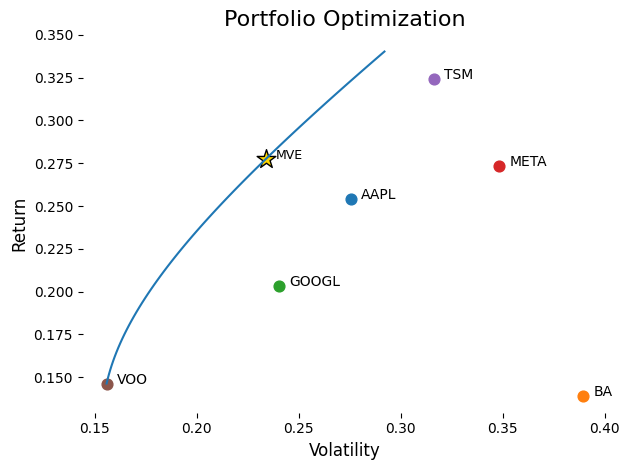

In [322]:
# Plotting Portfolio Frontier
fig, ax = plt.subplots()  # ⬅️ Increase plot area (width x height in inches)

# Plot Efficient Frontier
ax.plot(portfolio_stdev_list, portfolio_return_list,'-', label='Minimum Variance Portfolio')


# Mark MVE (Maximum Sharpe Portfolio)
plt.scatter(mve_stdev, mve_mean, color='gold', edgecolors='black', marker='*', s=200, label='MVE (Max Sharpe)')
plt.text(mve_stdev + 0.005, mve_mean, "MVE", fontsize=9)

# For each asset, plot its mean and stdev on the graph
for i in range(len(asset_names)):
    plt.scatter(asset_stdevs[i],asset_means[i], s=60, label = asset_names[i])
    plt.text(asset_stdevs[i]+0.005,asset_means[i],asset_names[i])

# Mark MVP (Minimum Variance Portfolio)
# plt.scatter(mvp_stdev, mvp_mean, color='black', marker='*', s=200, label='MVP (Min Variance)')
# plt.text(mvp_stdev + 0.001, mvp_mean, "MVP", fontsize=9)


# Step 4: Final formatting
for pos in ["top","bottom","left","right"]:
    ax.spines[pos].set_visible(False)
plt.title("Portfolio Optimization", fontsize=16)
plt.xlabel("Volatility", fontsize=12)
plt.ylabel("Return", fontsize=12)
# plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

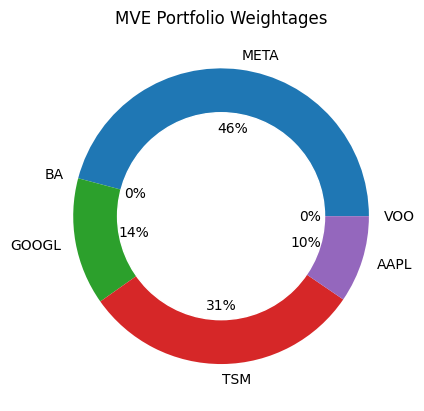

In [323]:
# Visualizing MVE Portfolio
ratios=[round(float(i*100),2) for i in max_sharpe_weights]
plt.pie(ratios,labels=assetlist , autopct='%.0f%%')
plt.title(label= "MVE Portfolio Weightages")

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

In [329]:
# Finding Capital Allocation Line

# Create weight range from 0 to 1 (inclusive) with 0.1 intervals
w_risky = np.round(np.arange(0, 1.05, 0.05), 3)
w_riskfree = np.round(1 - w_risky, 3)

# Create DataFrame with weight range
capital_allocation_weight = pd.DataFrame({
    "w1": w_risky,
    "w2": w_riskfree
})

# Create a range of return based on weightage
capital_allocation_return_list=[]
for index,row in capital_allocation_weight.iterrows():
    risky_return= row["w1"]*mve_mean
    riskfree_return= row["w2"]*asset_risk_free
    weighted_portfolio_return= risky_return+riskfree_return
    capital_allocation_return_list.append(weighted_portfolio_return)

# Calculate Variance for each weight
capital_allocation_variance_list=[]
for index, row in capital_allocation_weight.iterrows():
    total_volatility= (row["w1"])**2 *mve_stdev **2
    capital_allocation_variance_list.append(total_volatility)

# Calculate Standard Deviation for each weight
capital_allocation_stdev_list=[]
for var in capital_allocation_variance_list:
    capital_allocation_stdev_list.append((np.sqrt(var)))

# Calculate Sharpe Ratio for each weight
capital_allocation_sharpe_list=[]
for idx, weight in capital_allocation_weight.iterrows():
    capital_allocation_sharpe_list.append(mve_sharpe)

# Merge all data into df
capital_allocation_matrix=pd.DataFrame({
    "w(MVE)":w_risky,
    "w(Risk Free)":w_riskfree,
    "Mean Return":capital_allocation_return_list,
    "Variance":capital_allocation_variance_list,
    "Standard Deviation": capital_allocation_stdev_list,
    "Sharpe Ratio": capital_allocation_sharpe_list
})

Text(0.5, 1.0, 'Capital Allocation Line')

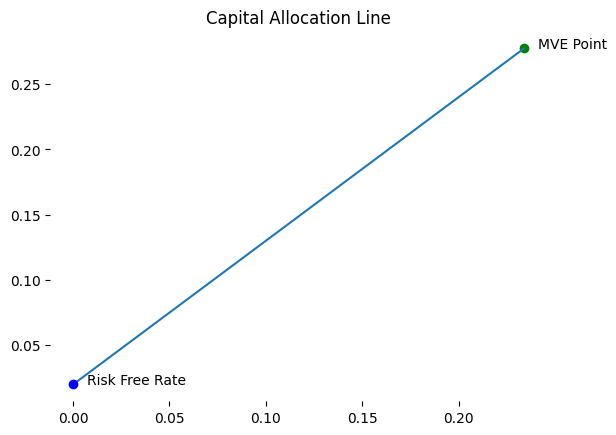

In [330]:
# Plotting CAL Line
fig,ax= plt.subplots()
#Plotting MVE Point
ax.plot(mve_stdev,mve_mean,"go")
plt.annotate(text=f"MVE Point",
             xy=(mve_stdev,mve_mean),
             textcoords="offset points",
             xytext=(10,0),
             ha="left")

#Plotting CAL Line
ax.plot(capital_allocation_stdev_list,capital_allocation_return_list,label="Capital Allocation Line")

# Annotating the Risk Free Rate
ax.plot(0,asset_risk_free,"bo")
plt.annotate(text=f"Risk Free Rate",
             xy=(0,asset_risk_free),
             textcoords="offset points",
             xytext=(10,0),
             ha="left")


# Plotting Capital Allocation line


# Formatting the Graph
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(label="Capital Allocation Line")